## Twitter Sentiment Analysis Classifier

### Setup

In [28]:
#!pip install evaluate transformers[torch] wandb

In [29]:
import wandb

# Initialize a W&B run
wandb.init(project='twitter_sentiment_classifier', entity='knebhi')

eval/accuracy,▁▇████
eval/f1,▁▇████
eval/loss,█▁▁▆▅▁
eval/runtime,▆▁█▂▂▂
eval/samples_per_second,▃█▁▇▇▇
eval/steps_per_second,▃█▁▇▇▇
test/accuracy,▁
test/f1,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁


In [30]:
# load data from s3 bucket
import boto3
import sagemaker

region_name = 'eu-central-1'

session = boto3.Session(region_name=region_name)
s3_sess = session.client('s3')
sm_session = sagemaker.Session(boto_session=session)

### Load Dataset

1. **Load CSV File**: Fetch the Twitter CSV file from the S3 bucket.
2. **Preprocessing**:
   - Remove tweets containing URLs.
   - Filter out tweets with fewer than 3 tokens.
3. **Create HF JSON Dataset**: Convert the cleaned data into a Hugging Face JSON dataset format. Training/Test/Validation
4. **Upload to S3**: Upload the processed HF JSON dataset back to the S3 bucket.


In [31]:
import pandas as pd
from io import StringIO

In [32]:
# Define the bucket name and the CSV file key (path in the bucket)
bucket_name = 'sagemaker-eu-central-1-505049265445'
csv_file_key = 'datasets/twitter_ds/twitter_dataset_full.csv'

# Fetch the CSV file content from S3
obj = s3_sess.get_object(Bucket=bucket_name, Key=csv_file_key)
data = obj['Body'].read().decode('utf-8')

# Convert the content to a pandas DataFrame
df = pd.read_csv(StringIO(data))

# Display the DataFrame
print(df.head())
print(df.shape)

   is_positive          id                      datetime           user  \
0            0  1467810672  Mon Apr 06 22:19:49 PDT 2009  scotthamilton   
1            0  1467810917  Mon Apr 06 22:19:53 PDT 2009       mattycus   
2            0  1467811184  Mon Apr 06 22:19:57 PDT 2009        ElleCTF   
3            0  1467811193  Mon Apr 06 22:19:57 PDT 2009         Karoli   
4            0  1467811372  Mon Apr 06 22:20:00 PDT 2009       joy_wolf   

                                             message  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   
(1599999, 5)


In [33]:
import re
# Function to check if a tweet has at least three tokens
def has_at_least_three_tokens(message):
    tokens = message.split()
    return len(tokens) >= 3

# Function to check if a tweet contains a URL
def contains_url(message):
    # Regex to detect URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return bool(re.search(url_pattern, message))

# Filter tweets with at least three tokens and no URLs
df_filtered = df[df['message'].apply(lambda x: has_at_least_three_tokens(x) and not contains_url(x))]


In [34]:
df_filtered.shape

(1498948, 5)

In [35]:
df_filtered = df_filtered[["message","is_positive"]]
df_filtered = df_filtered.rename(columns={'is_positive': 'label', 'message': 'text'})

In [36]:
df_sample = df_filtered.sample(n=1498948, random_state=42)  # 'random_state' ensures reproducibility
#df_sample = df  # 'random_state' ensures reproducibility

In [37]:
df_sample["label"].value_counts()

0    5151
1    4849
Name: label, dtype: int64

In [38]:
df_sample.shape

(10000, 2)

In [39]:
from datasets import Dataset, DatasetDict

# Drop the index from the DataFrame before conversion
df_sample.reset_index(drop=True, inplace=True)

# Convert the pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df_sample)

# Proceed with the train/test/validation split as before
train_testvalid = dataset.train_test_split(test_size=0.2, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

# Combine train, validation, and test sets into a DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

# Display the DatasetDict structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


In [40]:
# save train_dataset to s3 using our SageMaker session
input_path = f's3://{sm_session.default_bucket()}/datasets/twitter_ds/'

# save datasets to s3
dataset["train"].to_json(f"{input_path}/train/dataset.json", orient="records")
train_dataset_s3_path = f"{input_path}/train/dataset.json"
dataset["test"].to_json(f"{input_path}/test/dataset.json", orient="records")
test_dataset_s3_path = f"{input_path}/test/dataset.json"
dataset["validation"].to_json(f"{input_path}/validation/dataset.json", orient="records")
validation_dataset_s3_path = f"{input_path}/validation/dataset.json"


print(f"Training data uploaded to:")
print(train_dataset_s3_path)
print(test_dataset_s3_path)
print(validation_dataset_s3_path)

print(f"https://s3.console.aws.amazon.com/s3/buckets/{sm_session.default_bucket()}/?region={sm_session.boto_region_name}&prefix={input_path.split('/', 3)[-1]}/")

Creating json from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Training data uploaded to:
s3://sagemaker-eu-central-1-505049265445/datasets/twitter_ds//train/dataset.json
s3://sagemaker-eu-central-1-505049265445/datasets/twitter_ds//test/dataset.json
s3://sagemaker-eu-central-1-505049265445/datasets/twitter_ds//validation/dataset.json
https://s3.console.aws.amazon.com/s3/buckets/sagemaker-eu-central-1-505049265445/?region=eu-central-1&prefix=datasets/twitter_ds//


### Preprocessing

1. **Tokenize Dataset**: Use the RoBERTa tokenizer to tokenize the text data.
2. **Set Maximum Length**: Limit the tokenized sequences to a maximum length of 128 tokens.


In [41]:
model_id = "roberta-base"

In [42]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [43]:
tokenizer(dataset["train"][0]["text"])

{'input_ids': [0, 611, 1873, 225, 23, 10721, 1253, 13, 10, 828, 2156, 1303, 939, 300, 385, 17670, 27785, 1437, 1437, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [45]:
tokenized_train = dataset["train"].map(tokenize_function, batched=True)
tokenized_test = dataset["test"].map(tokenize_function, batched=True)
tokenized_validation = dataset["validation"].map(tokenize_function, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [46]:
unique_labels = set(dataset['test']['label'])
num_labels = len(unique_labels)
num_labels

2

### Model

1. **Model Selection**: Use the RoBERTa base model for sequence classification.
2. **Advantages of RoBERTa for Twitter Dataset**:
   - **Contextual Understanding**: RoBERTa's transformer-based architecture captures nuanced contextual information, which is crucial for understanding the diverse language and slang used in tweets.
   - **Pretraining Benefits**: RoBERTa is pretrained on a large corpus, which helps it handle various linguistic patterns and improve performance on tasks like sentiment analysis or topic classification.
   - **Robustness**: The model’s ability to handle long-range dependencies in text can enhance its effectiveness in processing and classifying tweets, which often include informal language and abbreviations.


In [47]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
import numpy as np 
import evaluate

# Load the evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    
    # Compute F1 score (use 'macro', 'micro', or 'weighted' depending on your task)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    # Return both metrics
    return {
        'accuracy': accuracy['accuracy'],  # Access the 'accuracy' key from the accuracy result
        'f1': f1['f1'],                    # Access the 'f1' key from the F1 result
    }

In [49]:
args = TrainingArguments(
    output_dir="../../model_saved/roberta-twitter-sa",  
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=16,  # Batch size for training 
    per_device_eval_batch_size=16,  # Batch size for evaluation 
    num_train_epochs=5,  # Number of epochs to train the model
    weight_decay=0.01,  # Weight decay for regularization to prevent overfitting
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy",  # Metric to determine the best model (accuracy in this case)
    save_total_limit=1,  # Limit the number of checkpoints to keep, only the most recent one is saved
    report_to='wandb'  # Report training metrics to Weights & Biases for experiment tracking
)

In [50]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

In [51]:
trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=2500, training_loss=0.2570807952880859, metrics={'train_runtime': 313.8375, 'train_samples_per_second': 127.455, 'train_steps_per_second': 7.966, 'total_flos': 2631110553600000.0, 'train_loss': 0.2570807952880859, 'epoch': 5.0})

In [52]:
trainer.evaluate()

{'eval_loss': 0.8474410772323608,
 'eval_accuracy': 0.849,
 'eval_f1': 0.8490176939124408,
 'eval_runtime': 2.0417,
 'eval_samples_per_second': 489.778,
 'eval_steps_per_second': 30.856,
 'epoch': 5.0}

In [53]:
# Perform evaluation on the validation dataset
test_results = trainer.predict(test_dataset=tokenized_validation)

In [54]:
# Extract predictions, labels, and metrics
predictions = test_results.predictions
labels = test_results.label_ids
metrics = test_results.metrics
metrics

{'test_loss': 0.8417901396751404,
 'test_accuracy': 0.845,
 'test_f1': 0.8450147303176446,
 'test_runtime': 2.1152,
 'test_samples_per_second': 472.764,
 'test_steps_per_second': 29.784}

### Final Results / Comparison to Bart Large MNLI model
- RoBERTa, fine-tuned on twitter dataset, achieved 0.89 accuracy and F1 score, outperforming zero-shot models like BART. 
- Its superior performance results from adapting to domain-specific nuances and being optimized for the task at hand.

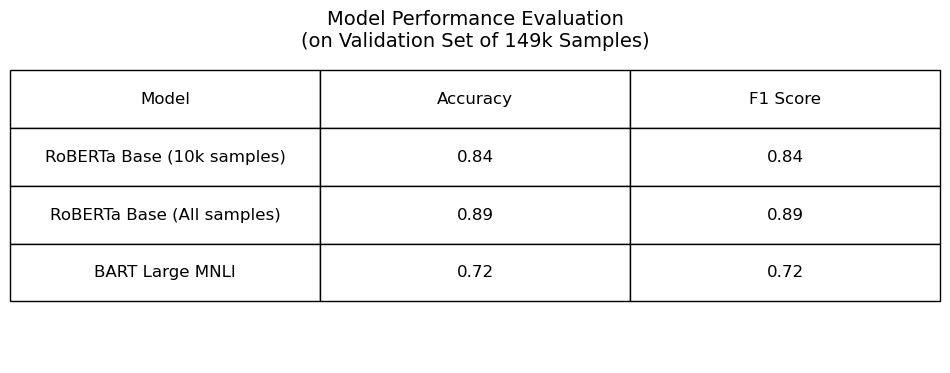

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with the results
data = {
    'Model': ['RoBERTa Base (10k samples)', 'RoBERTa Base (All samples)', 'BART Large MNLI'],
    'Accuracy': [0.84, 0.89, 0.72],
    'F1 Score': [0.84, 0.89, 0.72]
}

df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(12, 4))  # Adjust figsize as needed

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table
table = plt.table(cellText=df.values,
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0.2, 1, 0.75])  # Adjust bbox as needed for spacing

# Add title
plt.title('Model Performance Evaluation\n(on Validation Set of 149k Samples)', fontsize=14)

# Adjust table font size
table.auto_set_font_size(False)
table.set_fontsize(12)

# Show plot
plt.show()
